<a href="https://colab.research.google.com/github/paolo0o0/Orders/blob/main/Modeling_of_a_customer's_stream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [266]:
%pip install simpy
import simpy
import random
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

max_queue_per_sec = []
''' Создадим класс кинотеатр, ресурсами в котором будут кассы для покупки
билетов, пункты досмотра и кинозалы. А также три процесса: покупка билета,
прохождение пункта досмотра и проверка билета при входе в кинозал'''

class Cinema(object):
    def __init__(self, env, N_tickets_desk, N_security,
                 N_rooms, T_tickets, T_security, T_room_entrance):
        self.tickets_desk = simpy.Resource(env, capacity=N_tickets_desk)
        self.security = simpy.Resource(env, capacity=N_security)
        self.room = simpy.Resource(env, capacity=N_rooms)

        self.env = env
        self.T_tickets = T_tickets
        self.T_security = T_security
        self.T_room_entrance = T_room_entrance

    def buy_ticket(self, customer):
        # Обслуживание занимает T_tickets секунд
        yield self.env.timeout(self.T_tickets)

    def get_checked(self, customer):
        # Досмотр занимает T_security секунд
        yield self.env.timeout(self.T_security)

    def enter_the_room(self, customer):
        # Проверка билета на входе в кинозал занимает T_roome_entrance секунд
        yield self.env.timeout(self.T_room_entrance)

def compare_queue(resource, max):
    if len(resource.queue) > max:
        max = len(resource.queue)
    return max

# Создадим функцию, которая будет отвечать за поведение посетителя кинотеатра
def go_to_the_cinema(env, customer, cinema):
    # Запрос к ресурсу касс для покупки билетов
    with cinema.tickets_desk.request() as request:
        yield request
        yield env.process(cinema.buy_ticket(customer))
    # Запрос к ресурсу пунктов досмотра
    with cinema.security.request() as request:
        yield request
        yield env.process(cinema.get_checked(customer))
    # Запрос к ресурсу кинозалов
    with cinema.room.request() as request:
        yield request
        yield env.process(cinema.enter_the_room(customer))

# Создадим функцию генерации нормального распределения посетителей во времени
def normal_distribution(N, M):
    mean_objects_per_bin = N / M
    std_dev = 2
    distribution = np.random.normal(mean_objects_per_bin, std_dev, M)
    distribution = [int(max(0, round(x))) for x in distribution]

    while sum(distribution) != N:
        if sum(distribution) > N:
            for i in range(M):
                if distribution[i] > 0:
                    distribution[i] -= 1
                    if sum(distribution) == N:
                        break
        else:
            for i in range(M):
                distribution[i] += 1
                if sum(distribution) == N:
                    break
    return distribution

# Создадим функцию для запуска моделирования
def run_cinema(env, N_tickets_desk, N_security, N_rooms, T_tickets,
               T_security, T_room_entrance, T_before_start):
    # Считаем csv файл
    columns = ['room', 'start_time', 'number']
    data = pd.read_csv('cinema.csv', names=columns)

    cinema = Cinema(env, N_tickets_desk, N_security,
                    N_rooms, T_tickets, T_security, T_room_entrance)

    '''Заполним словарь из нормальных распределений посетителей во времени
     для каждого сеанса'''
    customers_per_sec = {i: normal_distribution(
        int(data.iloc[i, 2]), T_before_start * 60) for i in range(data.shape[0])}

    '''Список с временем начала прихода людей к каждому сеансу в секундах
    (Люди начинают приходить за T_before_start * 60 секунд до начала сеанса)'''
    start_time = []
    for j in range(data.shape[0]):
        start_time.append(
            ((int(data['start_time'][j][:3]) * 60 +
             int(data['start_time'][j][4:])) - T_before_start) * 60)

    '''Создадим список, элементами в котором будет количество людей,
    пришедших в кинотеатр каждую секунду'''
    customers = np.zeros((start_time[data.shape[0] - 1] + 2 * T_before_start * 60) -
                          start_time[0], dtype=int)

    '''Заполняем список customers значениями из списка customers_per_sec
    для тех промежутков времени, когда посетителю приходят на сеанс'''
    for sec in range(start_time[0],
                     start_time[data.shape[0] - 1] + 2 * T_before_start * 60):
        for i in range(data.shape[0]):
            if sec == start_time[i]:
                customers[sec - start_time[0]
                          : sec - start_time[0] + T_before_start * 60] \
                          = customers_per_sec[i]
    '''Проходимся по всему промежутку времени, и запускаем процесс
    только для тех секунд, в которые приходят посетители'''
    customer = 0
    for item in customers:
        yield env.timeout(1)
        max_queue_per_sec.append(max(len(cinema.tickets_desk.queue),
                                     len(cinema.security.queue),
                                     len(cinema.room.queue)))
        if item > 0:
            for i in range(item):
               customer += 1
               env.process(go_to_the_cinema(env, customer, cinema))

In [267]:
# Задаём все необходимые параметры
max_queue_per_sec = []
N_tickets_desk = 15
N_security = 7
N_rooms = 1
T_tickets = 60
T_security = 60
T_room_entrance = 10
T_before_start = 45

# Создаём среду и запускаем наш кинотеатр
env = simpy.Environment()
env.process(run_cinema(env, N_tickets_desk, N_security,
                       N_rooms, T_tickets, T_security,
                       T_room_entrance, T_before_start))
env.run()


In [268]:
'''Находим число 15 минутных интервалов, которые целиком помещаются
в наш временной промежуток наблюдения'''
size = len(max_queue_per_sec) // (15 * 60)

# Вычисляем длину оставшегося неполного интервала
remains = len(max_queue_per_sec) - size * 15 * 60
max_queue = []

'''Проходимся по всем 15 минутным пачкам и вычисляем максимальную
 длину очереди за данных интервал'''
for batch in range(size):
    max_queue.append(
        max(max_queue_per_sec[batch * 15 * 60 : (batch + 1) * 15 * 60]))
if remains != 0:
     max_queue.append(
          max(max_queue_per_sec[size * 15 * 60 : len(max_queue_per_sec)]))

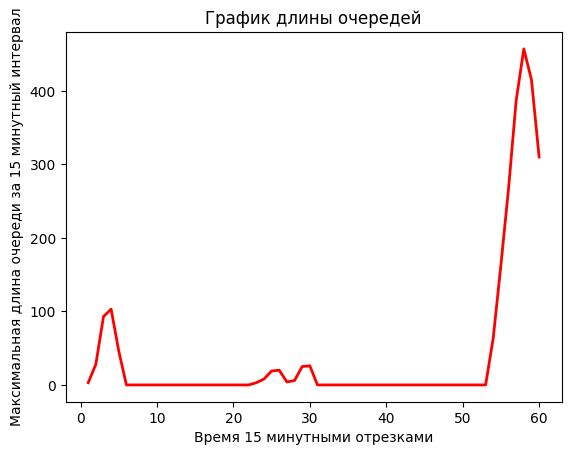

In [269]:
# Строим график
plt.plot(np.arange(len(max_queue)) + 1, max_queue,
         linewidth=2, color='r')
plt.title('График длины очередей')
plt.xlabel('Время 15 минутными отрезками')
plt.ylabel('Максимальная длина очереди за 15 минутный интервал')
plt.show()